<a href="https://colab.research.google.com/github/Krishnakanth1993/Learnings/blob/main/MNIST_Model/Reference/minimal_prameter_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [24]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [25]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([512, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([512])


# **Data Loading & Preprocessing**

In [26]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [27]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [28]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


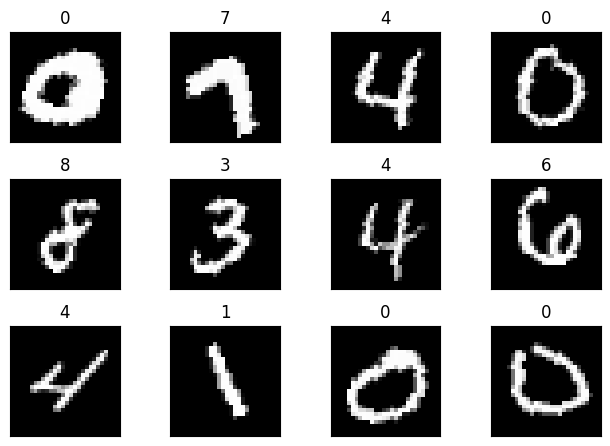

In [29]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [39]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) #28x28x1  | (3x3x1)32 | 28x28x32 RF 3x3
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1) #28x28x32 | (3x3x32)x32 | 28x28x32 RF 5x5
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1) #14x14x32 | (3x3x32)x16 | 14x14x16 RF 10x10
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1) #14x14x16  | (3x3x16)16 | 14x14x16 RF 12x12
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 8, kernel_size=3, padding=1) #7x7x16  | (3x3x16)x8 | 7x7x8 RF 24x24
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 8, kernel_size=3, padding=1) #7x7x8 | (3x3x8)x8 | 7x7x8 RF 26x26
        self.bn6 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 7 * 7, 10) #RF 26x26

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn5(self.conv5(x))
        x = F.relu(x)
        x = self.bn6(self.conv6(x))
        x = F.relu(x)
        x = x.view(-1, 8 * 7 * 7)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Training Setup

In [31]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [32]:
# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Shape: [batch_size]
            test_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)  # Average per sample
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [40]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.1051 Batch_id=117 Accuracy=88.78: 100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


Test set: Average loss: 0.0823, Accuracy: 9794/10000 (97.94%)

Epoch 2


Train: Loss=0.0410 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:17<00:00,  6.70it/s]


Test set: Average loss: 0.0473, Accuracy: 9868/10000 (98.68%)

Epoch 3


Train: Loss=0.1025 Batch_id=117 Accuracy=98.04: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0392, Accuracy: 9893/10000 (98.93%)

Epoch 4


Train: Loss=0.1186 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s]


Test set: Average loss: 0.0341, Accuracy: 9895/10000 (98.95%)

Epoch 5


Train: Loss=0.1584 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:18<00:00,  6.48it/s]


Test set: Average loss: 0.0398, Accuracy: 9872/10000 (98.72%)

Epoch 6


Train: Loss=0.0279 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:17<00:00,  6.60it/s]


Test set: Average loss: 0.0274, Accuracy: 9920/10000 (99.20%)

Epoch 7


Train: Loss=0.0240 Batch_id=117 Accuracy=98.73: 100%|██████████| 118/118 [00:17<00:00,  6.83it/s]


Test set: Average loss: 0.0298, Accuracy: 9899/10000 (98.99%)

Epoch 8


Train: Loss=0.0264 Batch_id=117 Accuracy=98.74: 100%|██████████| 118/118 [00:18<00:00,  6.43it/s]


Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)

Epoch 9


Train: Loss=0.0291 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:17<00:00,  6.68it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

Epoch 10


Train: Loss=0.0033 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:19<00:00,  6.11it/s]


Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.24%)

Epoch 11


Train: Loss=0.0453 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:17<00:00,  6.74it/s]


Test set: Average loss: 0.0195, Accuracy: 9932/10000 (99.32%)

Epoch 12


Train: Loss=0.0113 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

Epoch 13


Train: Loss=0.0772 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

Epoch 14


Train: Loss=0.0070 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

Epoch 15


Train: Loss=0.0171 Batch_id=117 Accuracy=99.27: 100%|██████████| 118/118 [00:18<00:00,  6.54it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

Epoch 16


Train: Loss=0.0269 Batch_id=117 Accuracy=99.20: 100%|██████████| 118/118 [00:17<00:00,  6.60it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

Epoch 17


Train: Loss=0.0514 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

Epoch 18


Train: Loss=0.0538 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

Epoch 19


Train: Loss=0.0274 Batch_id=117 Accuracy=99.26: 100%|██████████| 118/118 [00:19<00:00,  6.08it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

Epoch 20


Train: Loss=0.0209 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)



# Test Results

Text(0.5, 1.0, 'Test Accuracy')

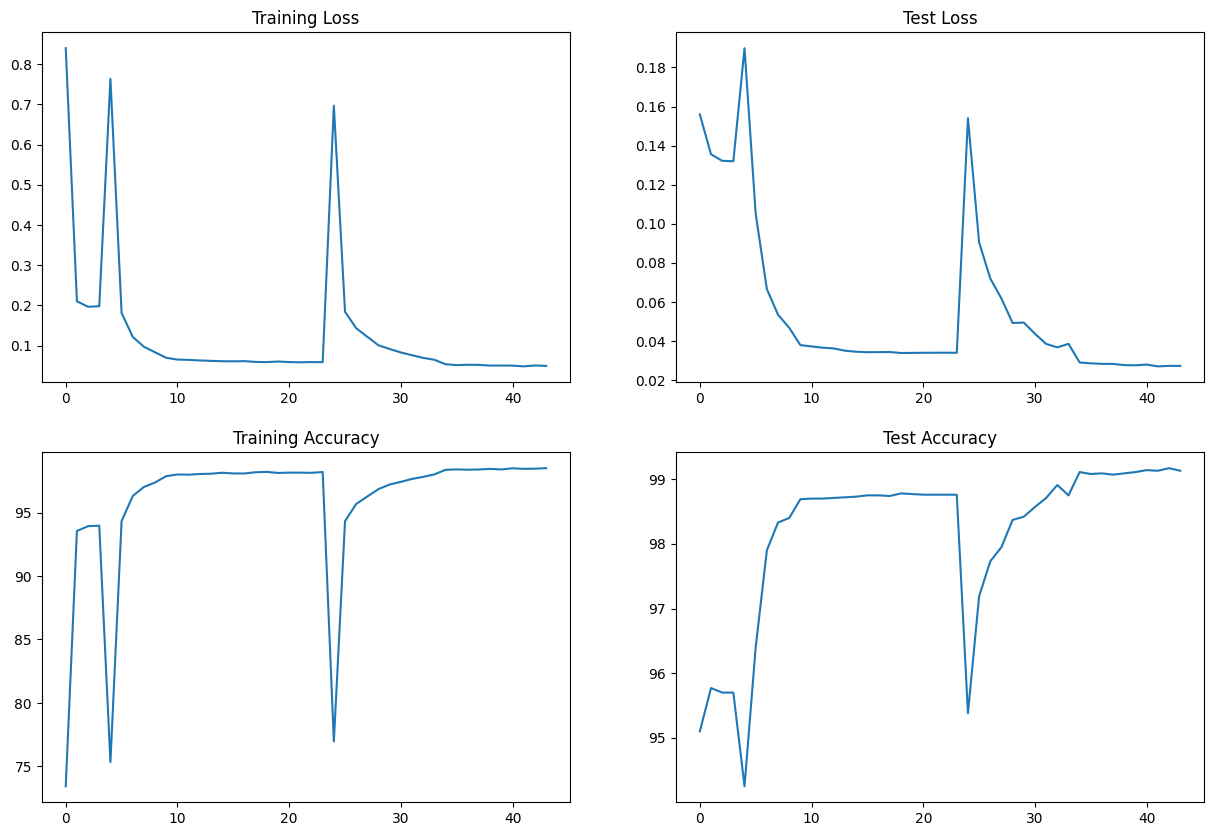

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
            Conv2d-3           [-1, 16, 14, 14]           4,624
            Conv2d-4           [-1, 16, 14, 14]           2,320
            Conv2d-5              [-1, 8, 7, 7]           1,160
            Conv2d-6              [-1, 8, 7, 7]             584
            Linear-7                   [-1, 10]           3,930
Total params: 22,186
Trainable params: 22,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.08
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


# Save and Visualize Model

In [ ]:
torch.save(model, "model.pt") ## does not include details of activation functions

In [ ]:
!pip install onnx
device = torch.device("cuda" if use_cuda else "cpu")

# Create dummy input with the same shape as your input
dummy_input = torch.randn(1, 1, 28, 28).to(device)  # Batch x Channels x Height x Width

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

/tmp/ipython-input-3254252982.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "model.onnx",


In [38]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=392, out_features=10, bias=True)
)

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.4 MB/s eta 0:00:00
